In [53]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from sklearn.metrics import roc_curve, auc
import random
import numpy as np
from torch.utils.data import Subset
from collections import Counter
from torch.optim.lr_scheduler import ReduceLROnPlateau

# 1. Chargement et préparation des ensembles de données : MVTec AD et AutoVI

## 1- AutoVI

In [61]:
# Chemins des dossiers pour AutoVI
autovi_train_dir = "AutoVI/engine_wiring/train"
autovi_test_dir = "AutoVI/engine_wiring/test"
"""
# Transformation avec data augmentation pour le dataset d'entraînement                 ( PAS une vraie data augmentattion --> voir chatgpt )
autovi_train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Flip horizontal aléatoire
    transforms.RandomRotation(degrees=15),  # Rotation aléatoire jusqu'à 15°
    transforms.RandomResizedCrop((128, 128), scale=(0.8, 1.0)),  # Crop aléatoire
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Modification des couleurs
    transforms.ToTensor(),  # Convertit en tenseurs
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalisation
])
"""
# Transformation standard pour le test (sans augmentation)
autovi_train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Transformation standard pour le test (sans augmentation)
autovi_test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Chargement du dataset d'entraînement avec augmentation
autovi_train_dataset = datasets.ImageFolder(
    root=autovi_train_dir,
    transform=autovi_train_transform
)

# Chargement du dataset de test (sans augmentation)
autovi_test_dataset = datasets.ImageFolder(
    root=autovi_test_dir,
    transform=autovi_test_transform
)

# Création des DataLoaders pour AutoVI
autovi_train_loader = DataLoader(autovi_train_dataset, batch_size=16, shuffle=True)
autovi_test_loader = DataLoader(autovi_test_dataset, batch_size=16, shuffle=False)

# Vérification des classes chargées pour AutoVI
print(f"Classes dans le train (AutoVI) : {autovi_train_dataset.classes}")
print(f"Classes dans le test (AutoVI) : {autovi_test_dataset.classes}")



Classes dans le train (AutoVI) : ['good']
Classes dans le test (AutoVI) : ['blue_hoop', 'cardboard', 'fastening', 'good', 'multiple', 'obstruction']


In [62]:

# Trouver l'indice correspondant à la classe "good" dans le dataset de test
good_class_idx = autovi_test_dataset.class_to_idx['good']

# Filtrer les indices des échantillons correspondant à la classe "good"
good_indices = [i for i, (_, label) in enumerate(autovi_test_dataset) if label == good_class_idx]

# Créer un dataset réduit contenant uniquement les images de la classe "good"
filtered_autovi_test_dataset = Subset(autovi_test_dataset, good_indices)

# DataLoader pour le dataset filtré
filtered_autovi_test_loader = DataLoader(filtered_autovi_test_dataset, batch_size=16, shuffle=False)

# Vérification
print(f"Nombre d'images de la classe 'good' dans le test : {len(filtered_autovi_test_dataset)}")


Nombre d'images de la classe 'good' dans le test : 285


Nombre d'images dans le train (AutoVI) : 285
Nombre d'images dans le test (AutoVI) : 607


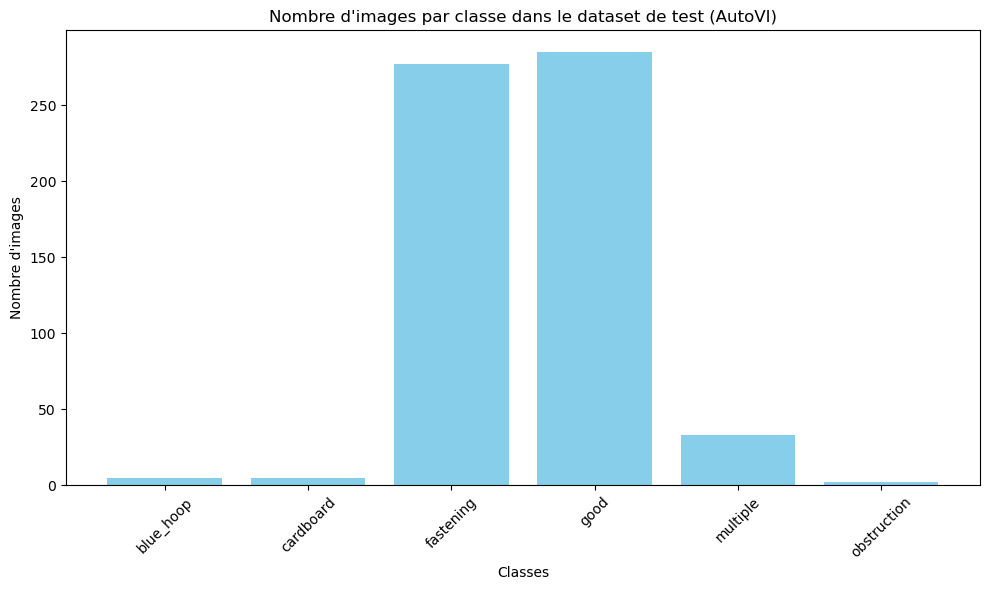

In [26]:

# Nombre total d'images dans le train et le test
num_train_images = len(autovi_train_dataset)
num_test_images = len(autovi_test_dataset)

print(f"Nombre d'images dans le train (AutoVI) : {num_train_images}")
print(f"Nombre d'images dans le test (AutoVI) : {num_test_images}")

# Comptage des images par classe dans le dataset de test
class_counts = Counter([label for _, label in autovi_test_dataset])
class_names = autovi_test_dataset.classes
class_image_counts = {class_names[class_id]: count for class_id, count in class_counts.items()}

# Création du barplot
plt.figure(figsize=(10, 6))
plt.bar(class_image_counts.keys(), class_image_counts.values(), color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Nombre d\'images')
plt.title('Nombre d\'images par classe dans le dataset de test (AutoVI)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


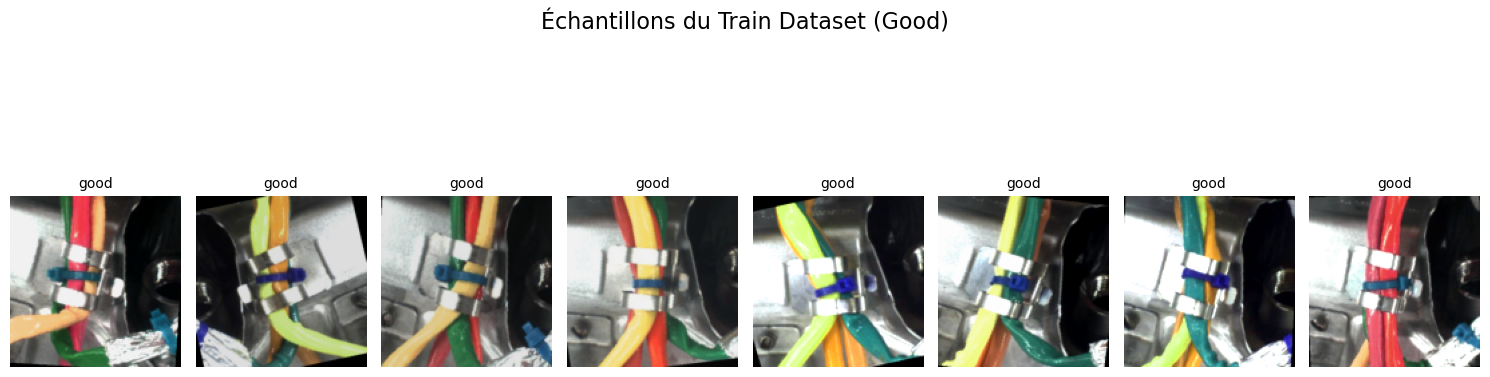

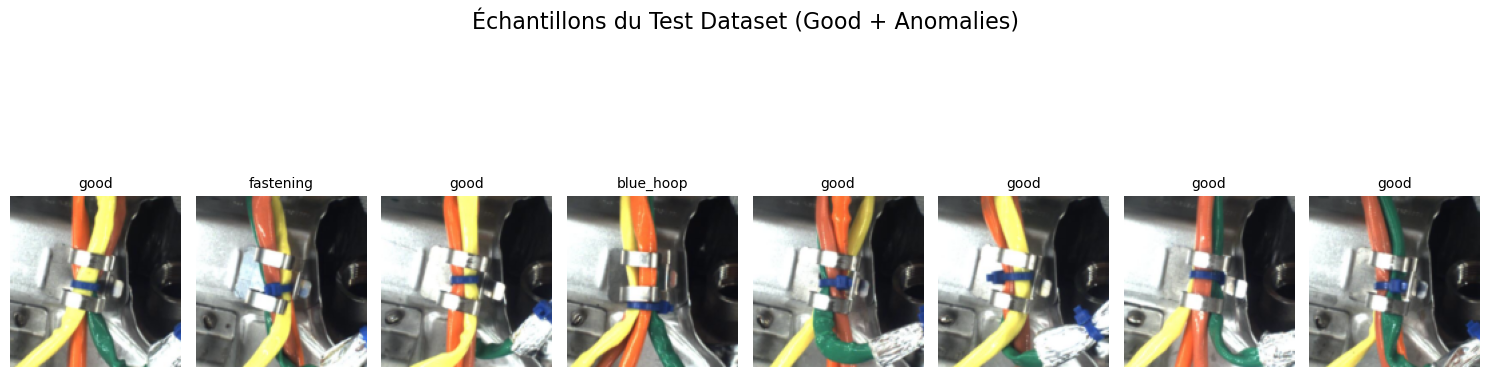

In [27]:

def plot_samples(dataset, title, n_samples=8):
    """
    Affiche des échantillons d'images du dataset avec leurs labels.

    Args:
        dataset (torch.utils.data.Dataset): Dataset à visualiser.
        title (str): Titre global du graphique.
        n_samples (int): Nombre d'échantillons à afficher.
    """
    # Sélection d'échantillons aléatoires
    indices = torch.randint(0, len(dataset), (n_samples,))
    samples = [dataset[i] for i in indices]
    images, labels = zip(*samples)
    
    # Création de la grille d'images
    fig, axes = plt.subplots(1, n_samples, figsize=(15, 5))
    fig.suptitle(title, fontsize=16)
    
    for i, (img, label) in enumerate(zip(images, labels)):
        img = img.permute(1, 2, 0).numpy()  # Convertir Tensor en numpy
        img = (img * 0.5) + 0.5  # Inverser la normalisation
        
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(dataset.classes[label], fontsize=10)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Exemple d'utilisation
# Affiche des échantillons du train_loader et test_loader
plot_samples(autovi_train_dataset, "Échantillons du Train Dataset (Good)", n_samples=8)
plot_samples(autovi_test_dataset, "Échantillons du Test Dataset (Good + Anomalies)", n_samples=8)


## 1.2- MVTecAD

### 1.2.1- Bottle

In [103]:
bottle_train_dir = "MVTecAD/bottle/bottle/train"
bottle_test_dir = "MVTecAD/bottle/bottle/test"

# Transformation standard pour le test (sans augmentation)
bottle_train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Transformation standard pour le test (sans augmentation)
bottle_test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Chargement du dataset d'entraînement avec augmentation
bottle_train_dataset = datasets.ImageFolder(
    root=bottle_train_dir,
    transform=bottle_train_transform
)

# Chargement du dataset de test (sans augmentation)
bottle_test_dataset = datasets.ImageFolder(
    root=bottle_test_dir,
    transform=bottle_test_transform
)

# Création des DataLoaders pour AutoVI
bottle_train_loader = DataLoader(bottle_train_dataset, batch_size=16, shuffle=True)
bottle_test_loader = DataLoader(bottle_test_dataset, batch_size=16, shuffle=False)

# Vérification des classes chargées pour AutoVI
print(f"Classes dans le train (Bottle) : {bottle_train_dataset.classes}")
print(f"Classes dans le test (Bottle) : {bottle_test_dataset.classes}")


Classes dans le train (Bottle) : ['good']
Classes dans le test (Bottle) : ['broken_large', 'broken_small', 'contamination', 'good']


In [104]:
# Trouver l'indice correspondant à la classe "good" dans le dataset de test
good_class_idx = bottle_test_dataset.class_to_idx['good']

# Filtrer les indices des échantillons correspondant à la classe "good"
good_indices = [i for i, (_, label) in enumerate(bottle_test_dataset) if label == good_class_idx]

# Créer un dataset réduit contenant uniquement les images de la classe "good"
filtered_bottle_test_dataset = Subset(bottle_test_dataset, good_indices)

# DataLoader pour le dataset filtré
filtered_bottle_test_loader = DataLoader(filtered_bottle_test_dataset, batch_size=16, shuffle=False)

# Vérification
print(f"Nombre d'images de la classe 'good' dans le test : {len(filtered_bottle_test_dataset)}")


Nombre d'images de la classe 'good' dans le test : 20


Nombre d'images dans le train (Bottle) : 209
Nombre d'images dans le test (Bottle) : 83


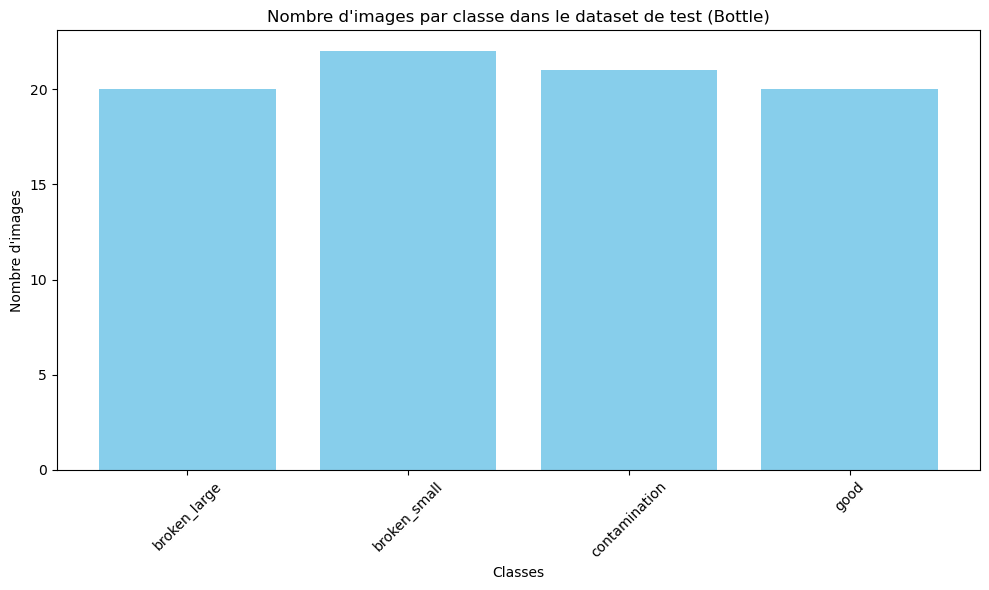

In [105]:
# Nombre total d'images dans le train et le test
num_train_images = len(bottle_train_dataset)
num_test_images = len(bottle_test_dataset)

print(f"Nombre d'images dans le train (Bottle) : {num_train_images}")
print(f"Nombre d'images dans le test (Bottle) : {num_test_images}")

# Comptage des images par classe dans le dataset de test
class_counts = Counter([label for _, label in bottle_test_dataset])
class_names = bottle_test_dataset.classes
class_image_counts = {class_names[class_id]: count for class_id, count in class_counts.items()}

# Création du barplot
plt.figure(figsize=(10, 6))
plt.bar(class_image_counts.keys(), class_image_counts.values(), color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Nombre d\'images')
plt.title('Nombre d\'images par classe dans le dataset de test (Bottle)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

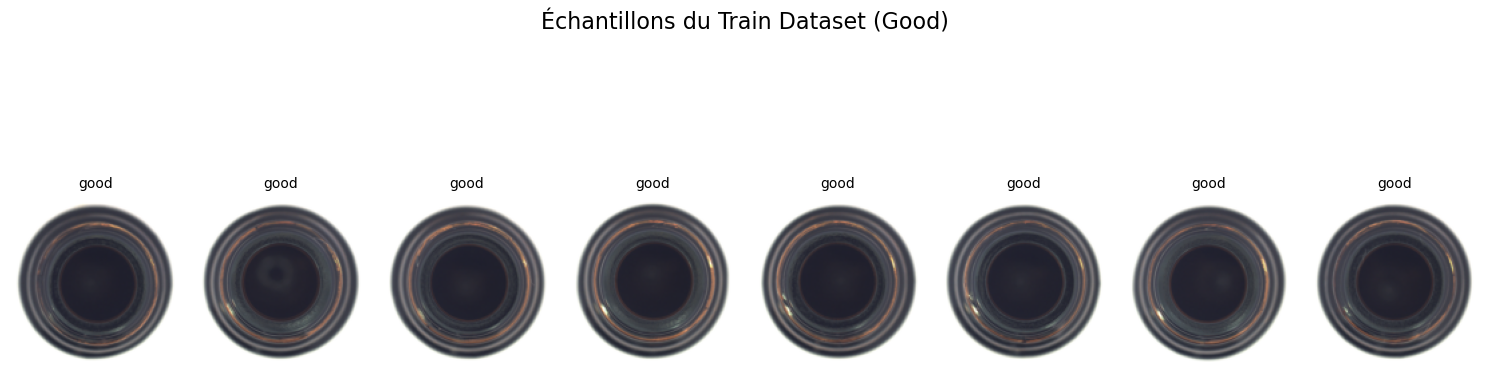

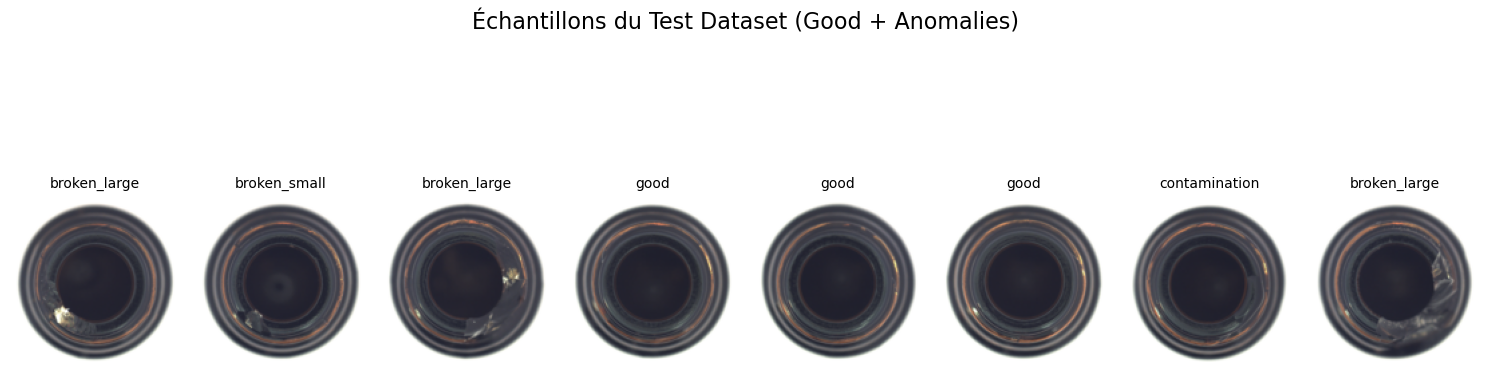

In [106]:
plot_samples(bottle_train_dataset, "Échantillons du Train Dataset (Good)", n_samples=8)
plot_samples(bottle_test_dataset, "Échantillons du Test Dataset (Good + Anomalies)", n_samples=8)

### 1.2.2- Capsule

In [108]:
capsule_train_dir = "MVTecAD/capsule/capsule/train"
capsule_test_dir = "MVTecAD/capsule/capsule/test"

# Transformation standard pour le test (sans augmentation)
capsule_train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Transformation standard pour le test (sans augmentation)
capsule_test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Chargement du dataset d'entraînement avec augmentation
capsule_train_dataset = datasets.ImageFolder(
    root=capsule_train_dir,
    transform=capsule_train_transform
)

# Chargement du dataset de test (sans augmentation)
capsule_test_dataset = datasets.ImageFolder(
    root=capsule_test_dir,
    transform=capsule_test_transform
)

# Création des DataLoaders pour AutoVI
capsule_train_loader = DataLoader(capsule_train_dataset, batch_size=16, shuffle=True)
capsule_test_loader = DataLoader(capsule_test_dataset, batch_size=16, shuffle=False)

# Vérification des classes chargées pour AutoVI
print(f"Classes dans le train (Capsule) : {capsule_train_dataset.classes}")
print(f"Classes dans le test (Capsule) : {capsule_test_dataset.classes}")



Classes dans le train (Capsule) : ['good']
Classes dans le test (Capsule) : ['crack', 'faulty_imprint', 'good', 'poke', 'scratch', 'squeeze']


In [109]:
# Trouver l'indice correspondant à la classe "good" dans le dataset de test
good_class_idx = capsule_test_dataset.class_to_idx['good']

# Filtrer les indices des échantillons correspondant à la classe "good"
good_indices = [i for i, (_, label) in enumerate(capsule_test_dataset) if label == good_class_idx]

# Créer un dataset réduit contenant uniquement les images de la classe "good"
filtered_capsule_test_dataset = Subset(capsule_test_dataset, good_indices)

# DataLoader pour le dataset filtré
filtered_capsule_test_loader = DataLoader(filtered_capsule_test_dataset, batch_size=16, shuffle=False)

# Vérification
print(f"Nombre d'images de la classe 'good' dans le test : {len(filtered_capsule_test_dataset)}")


Nombre d'images de la classe 'good' dans le test : 23


Nombre d'images dans le train (Capsule) : 219
Nombre d'images dans le test (Capsule) : 132


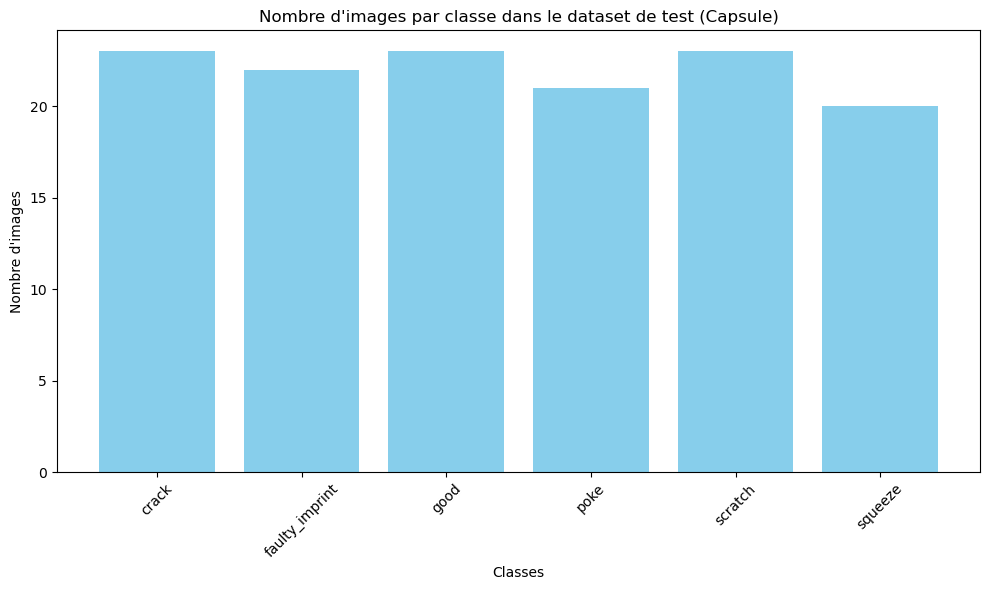

In [110]:
# Nombre total d'images dans le train et le test
num_train_images = len(capsule_train_dataset)
num_test_images = len(capsule_test_dataset)

print(f"Nombre d'images dans le train (Capsule) : {num_train_images}")
print(f"Nombre d'images dans le test (Capsule) : {num_test_images}")

# Comptage des images par classe dans le dataset de test
class_counts = Counter([label for _, label in capsule_test_dataset])
class_names = capsule_test_dataset.classes
class_image_counts = {class_names[class_id]: count for class_id, count in class_counts.items()}

# Création du barplot
plt.figure(figsize=(10, 6))
plt.bar(class_image_counts.keys(), class_image_counts.values(), color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Nombre d\'images')
plt.title('Nombre d\'images par classe dans le dataset de test (Capsule)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


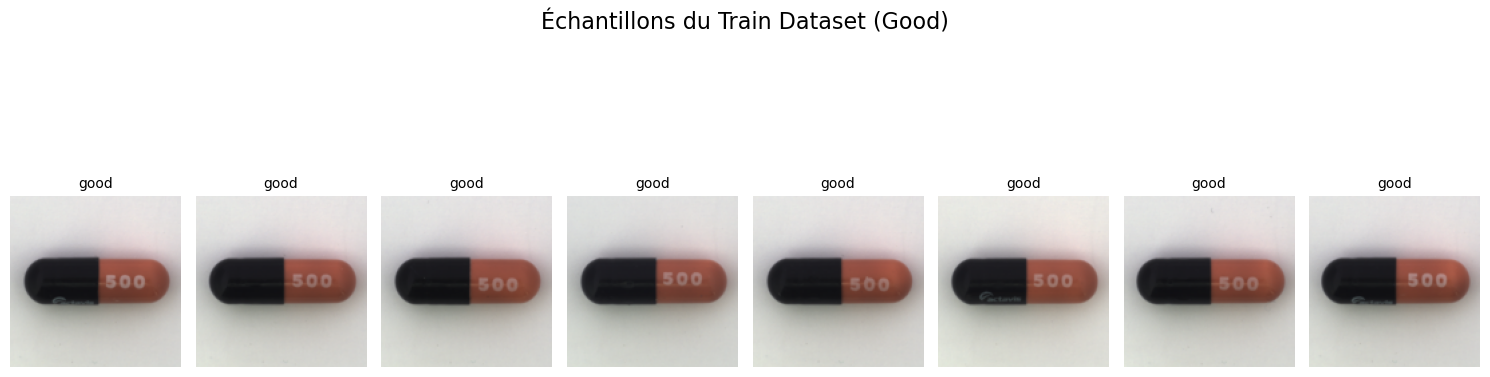

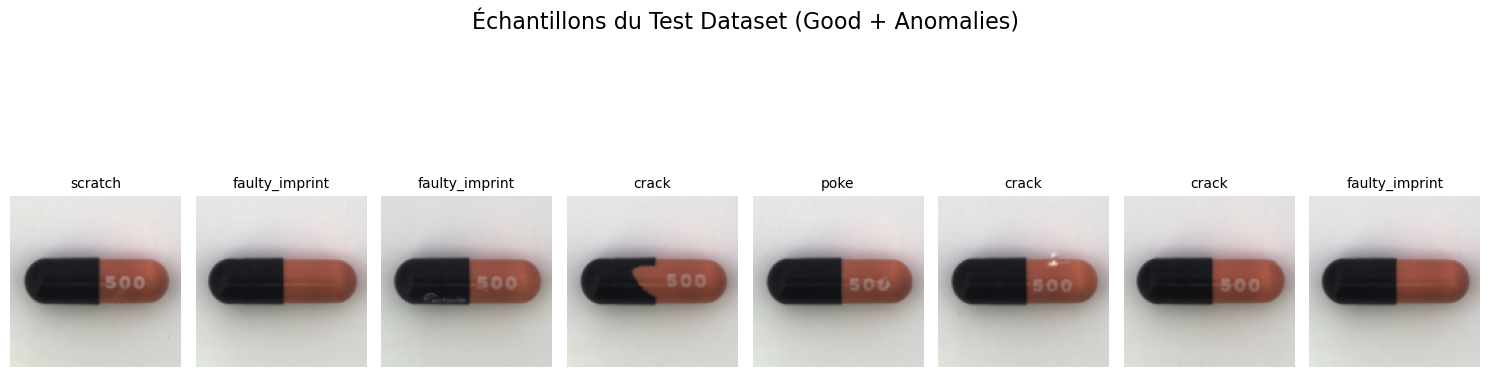

In [111]:
plot_samples(capsule_train_dataset, "Échantillons du Train Dataset (Good)", n_samples=8)
plot_samples(capsule_test_dataset, "Échantillons du Test Dataset (Good + Anomalies)", n_samples=8)

### 1.2.3- Hazelnut

In [112]:
hazelnut_train_dir = "MVTecAD/hazelnut/hazelnut/train"
hazelnut_test_dir = "MVTecAD/hazelnut/hazelnut/test"

# Transformation standard pour le test (sans augmentation)
hazelnut_train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Transformation standard pour le test (sans augmentation)
hazelnut_test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Chargement du dataset d'entraînement avec augmentation
hazelnut_train_dataset = datasets.ImageFolder(
    root=hazelnut_train_dir,
    transform=hazelnut_train_transform
)

# Chargement du dataset de test (sans augmentation)
hazelnut_test_dataset = datasets.ImageFolder(
    root=hazelnut_test_dir,
    transform=hazelnut_test_transform
)

# Création des DataLoaders pour AutoVI
hazelnut_train_loader = DataLoader(hazelnut_train_dataset, batch_size=16, shuffle=True)
hazelnut_test_loader = DataLoader(hazelnut_test_dataset, batch_size=16, shuffle=False)

# Vérification des classes chargées pour AutoVI
print(f"Classes dans le train (Hazelnut) : {hazelnut_train_dataset.classes}")
print(f"Classes dans le test (Hazelnut) : {hazelnut_test_dataset.classes}")


Classes dans le train (Hazelnut) : ['good']
Classes dans le test (Hazelnut) : ['crack', 'cut', 'good', 'hole', 'print']


In [113]:
# Trouver l'indice correspondant à la classe "good" dans le dataset de test
good_class_idx = hazelnut_test_dataset.class_to_idx['good']

# Filtrer les indices des échantillons correspondant à la classe "good"
good_indices = [i for i, (_, label) in enumerate(hazelnut_test_dataset) if label == good_class_idx]

# Créer un dataset réduit contenant uniquement les images de la classe "good"
filtered_hazelnut_test_dataset = Subset(hazelnut_test_dataset, good_indices)

# DataLoader pour le dataset filtré
filtered_hazelnut_test_loader = DataLoader(filtered_hazelnut_test_dataset, batch_size=16, shuffle=False)

# Vérification
print(f"Nombre d'images de la classe 'good' dans le test : {len(filtered_hazelnut_test_dataset)}")


Nombre d'images de la classe 'good' dans le test : 40


Nombre d'images dans le train (Hazelnut) : 391
Nombre d'images dans le test (Hazelnut) : 110


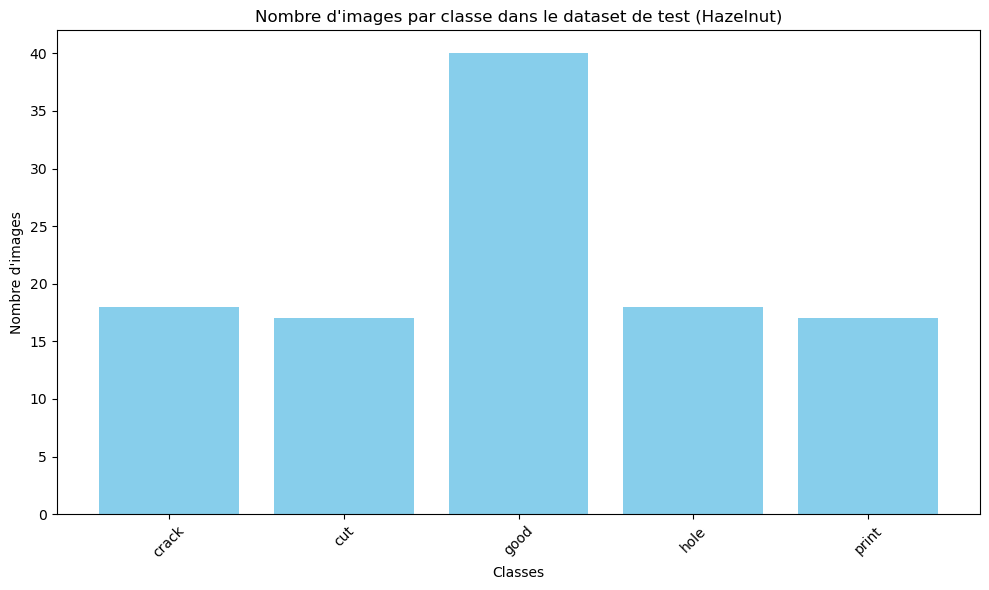

In [114]:
# Nombre total d'images dans le train et le test
num_train_images = len(hazelnut_train_dataset)
num_test_images = len(hazelnut_test_dataset)

print(f"Nombre d'images dans le train (Hazelnut) : {num_train_images}")
print(f"Nombre d'images dans le test (Hazelnut) : {num_test_images}")

# Comptage des images par classe dans le dataset de test
class_counts = Counter([label for _, label in hazelnut_test_dataset])
class_names = hazelnut_test_dataset.classes
class_image_counts = {class_names[class_id]: count for class_id, count in class_counts.items()}

# Création du barplot
plt.figure(figsize=(10, 6))
plt.bar(class_image_counts.keys(), class_image_counts.values(), color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Nombre d\'images')
plt.title('Nombre d\'images par classe dans le dataset de test (Hazelnut)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


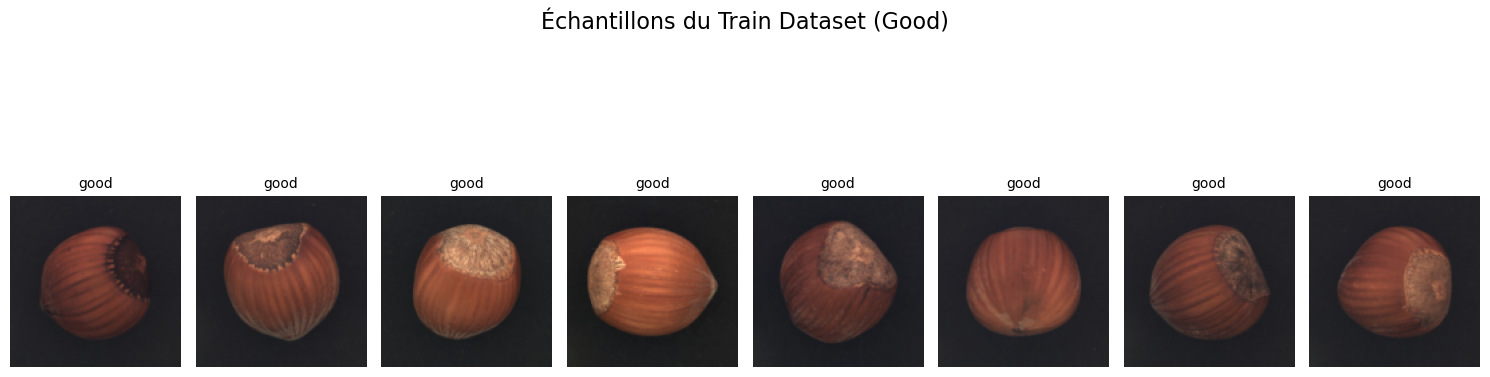

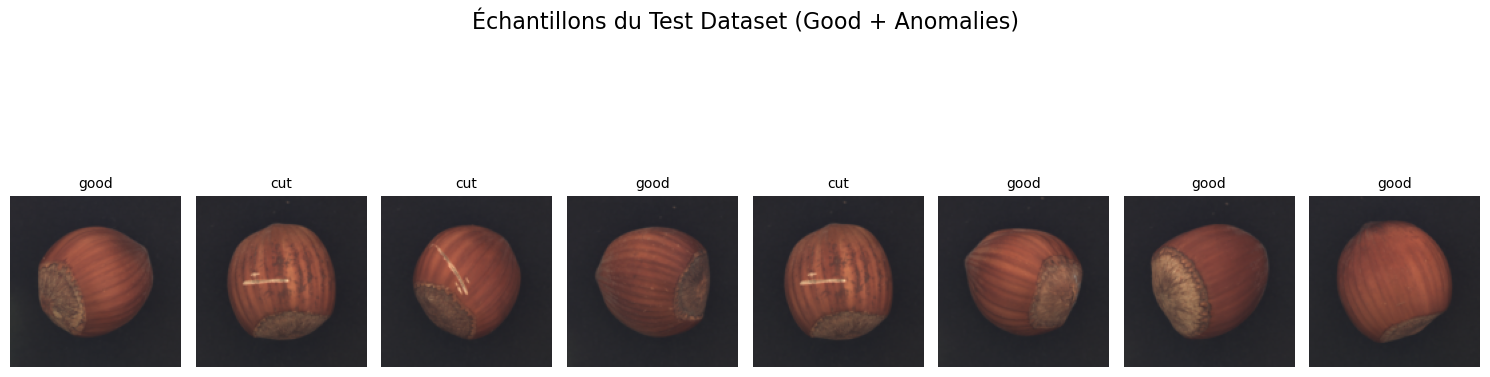

In [118]:
plot_samples(hazelnut_train_dataset, "Échantillons du Train Dataset (Good)", n_samples=8)
plot_samples(hazelnut_test_dataset, "Échantillons du Test Dataset (Good + Anomalies)", n_samples=8)

### 1.2.4- Toothbrush

In [119]:
toothbrush_train_dir = "MVTecAD/toothbrush/toothbrush/train"
toothbrush_test_dir = "MVTecAD/toothbrush/toothbrush/test"

# Transformation standard pour le test (sans augmentation)
toothbrush_train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Transformation standard pour le test (sans augmentation)
toothbrush_test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Chargement du dataset d'entraînement avec augmentation
toothbrush_train_dataset = datasets.ImageFolder(
    root=toothbrush_train_dir,
    transform=toothbrush_train_transform
)

# Chargement du dataset de test (sans augmentation)
toothbrush_test_dataset = datasets.ImageFolder(
    root=toothbrush_test_dir,
    transform=toothbrush_test_transform
)

# Création des DataLoaders pour AutoVI
toothbrush_train_loader = DataLoader(toothbrush_train_dataset, batch_size=16, shuffle=True)
toothbrush_test_loader = DataLoader(toothbrush_test_dataset, batch_size=16, shuffle=False)

# Vérification des classes chargées pour AutoVI
print(f"Classes dans le train (Toothbrush) : {toothbrush_train_dataset.classes}")
print(f"Classes dans le test (Toothbrush) : {toothbrush_test_dataset.classes}")


Classes dans le train (Toothbrush) : ['good']
Classes dans le test (Toothbrush) : ['defective', 'good']


In [120]:
# Trouver l'indice correspondant à la classe "good" dans le dataset de test
good_class_idx = toothbrush_test_dataset.class_to_idx['good']

# Filtrer les indices des échantillons correspondant à la classe "good"
good_indices = [i for i, (_, label) in enumerate(toothbrush_test_dataset) if label == good_class_idx]

# Créer un dataset réduit contenant uniquement les images de la classe "good"
filtered_toothbrush_test_dataset = Subset(toothbrush_test_dataset, good_indices)

# DataLoader pour le dataset filtré
filtered_toothbrush_test_loader = DataLoader(filtered_toothbrush_test_dataset, batch_size=16, shuffle=False)

# Vérification
print(f"Nombre d'images de la classe 'good' dans le test : {len(filtered_toothbrush_test_dataset)}")


Nombre d'images de la classe 'good' dans le test : 12


Nombre d'images dans le train (Toothbrush) : 60
Nombre d'images dans le test (Toothbrush) : 42


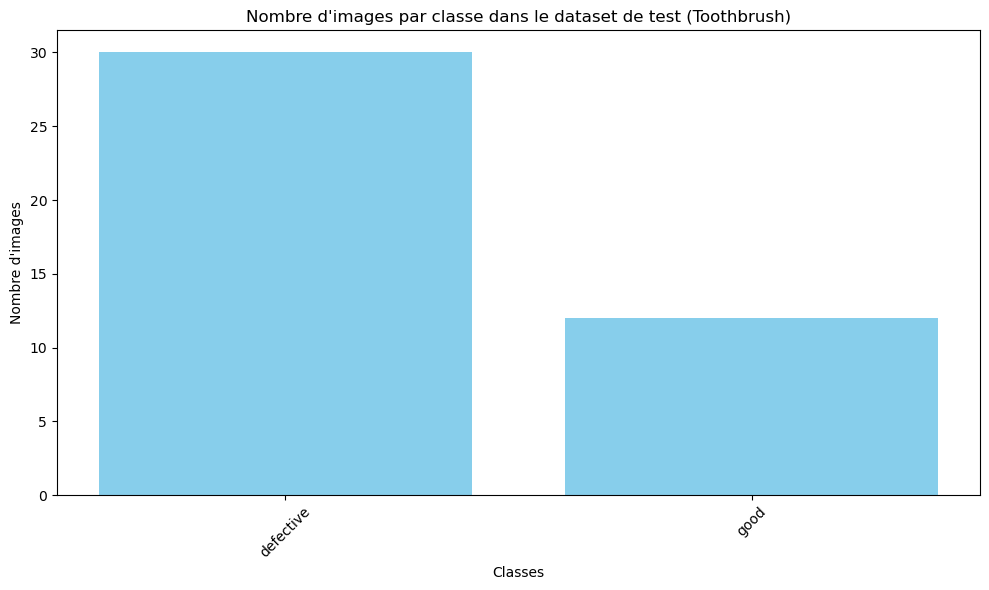

In [121]:
# Nombre total d'images dans le train et le test
num_train_images = len(toothbrush_train_dataset)
num_test_images = len(toothbrush_test_dataset)

print(f"Nombre d'images dans le train (Toothbrush) : {num_train_images}")
print(f"Nombre d'images dans le test (Toothbrush) : {num_test_images}")

# Comptage des images par classe dans le dataset de test
class_counts = Counter([label for _, label in toothbrush_test_dataset])
class_names = toothbrush_test_dataset.classes
class_image_counts = {class_names[class_id]: count for class_id, count in class_counts.items()}

# Création du barplot
plt.figure(figsize=(10, 6))
plt.bar(class_image_counts.keys(), class_image_counts.values(), color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Nombre d\'images')
plt.title('Nombre d\'images par classe dans le dataset de test (Toothbrush)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


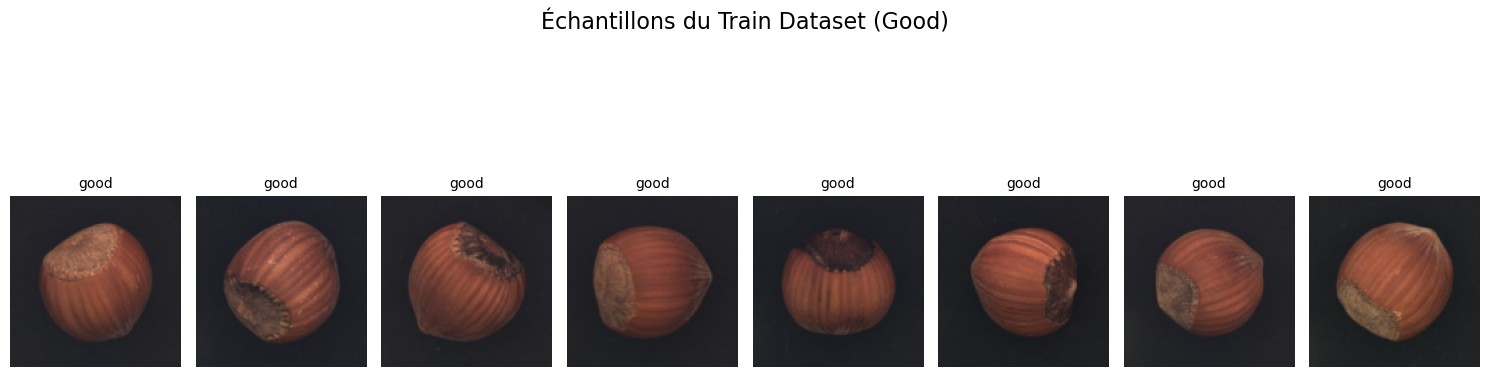

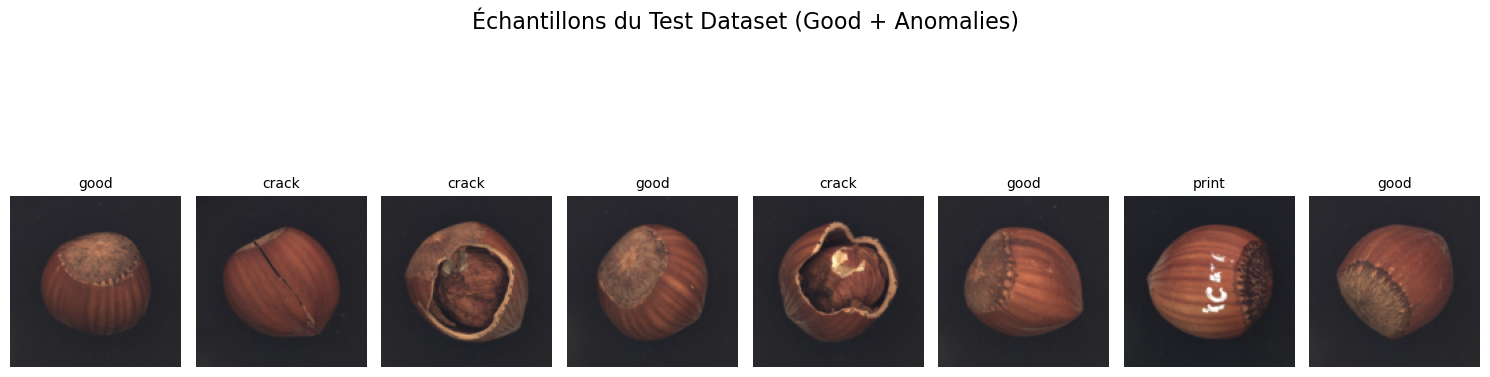

In [122]:
plot_samples(hazelnut_train_dataset, "Échantillons du Train Dataset (Good)", n_samples=8)
plot_samples(hazelnut_test_dataset, "Échantillons du Test Dataset (Good + Anomalies)", n_samples=8)

# 2. Mise en place de plusieurs modèles SSL

In [69]:
def train_ssl_model(model, 
                    train_loader, 
                    test_loader, 
                    criterion,
                    optimizer,
                    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
                    epochs=25):  # Exemple avec 25 époques
    """
    Entraîne un modèle SSL et retourne les pertes d'entraînement et de validation.
    """
    train_losses = []
    val_losses = []
    
    # Déplacer le modèle sur l'appareil
    model.to(device)
    
    # Initialisation du scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)
    
    for epoch in range(epochs):
        # Entraînement
        model.train()
        total_train_loss = 0
        for images, _ in train_loader:
            images = images.to(device)
            optimizer.zero_grad()
            output, _ = model(images)
            loss = criterion(output, images)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for images, _ in test_loader:
                images = images.to(device)
                output, _ = model(images)
                loss = criterion(output, images)
                total_val_loss += loss.item()
        avg_val_loss = total_val_loss / len(test_loader)
        val_losses.append(avg_val_loss)
        
        # Mise à jour du scheduler
        scheduler.step(avg_val_loss)
        
        # Affichage du LR après chaque mise à jour
        for param_group in optimizer.param_groups:
            current_lr = param_group['lr']
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Current LR: {current_lr:.6f}")
        
        # Forcer la réduction du learning rate à la 20ᵉ époque
        if epoch == 19:  # À la 20ᵉ époque (indexée à 19)
            for param_group in optimizer.param_groups:
                current_lr = param_group['lr']
                new_lr = current_lr * 0.5
                param_group['lr'] = new_lr
            print(f"Forced LR reduction at epoch {epoch + 1}. New LR: {new_lr:.6f}")
    
    return model.encoder, train_losses, val_losses


In [29]:


# Visualize colorization on random test images

def visualize_reconstructions(model, data_loader, device, num_images=5):
    # Set the model to evaluation mode
    model.eval()

    # Convert the DataLoader to a list to randomly sample images
    dataset = list(data_loader.dataset)

    # Randomly select `num_images` images from the dataset
    random_indices = random.sample(range(len(dataset)), num_images)
    random_images = [dataset[i][0] for i in random_indices]  # Extract only the images, ignoring labels

    # Stack the images into a batch
    images = torch.stack(random_images)

    # Move images to the specified device
    images = images.to(device)
    
    # Run the grayscale images through the colorization model
    with torch.no_grad():
        reconstructed_images, perturbed_images = model(images)
    
    # Move images back to CPU for visualization
    images = images.cpu()
    reconstructed_images = reconstructed_images.cpu()
    perturbed_images = perturbed_images.cpu()
    
    # Plot the grayscale, ground truth, and colorized images
    fig, axes = plt.subplots(num_images, 3, figsize=(10, num_images * 4))
    for i in range(num_images):
        # Grayscale input
        axes[i, 0].imshow(perturbed_images[i].permute(1, 2, 0).squeeze(), cmap='gray')
        axes[i, 0].set_title("Grayscale Input")
        axes[i, 0].axis('off')
        
        # Ground truth (original RGB image)
        axes[i, 1].imshow(images[i].permute(1, 2, 0))
        axes[i, 1].set_title("Ground Truth (RGB)")
        axes[i, 1].axis('off')
        
        # Colorized output from the model
        axes[i, 2].imshow(reconstructed_images[i].permute(1, 2, 0))
        axes[i, 2].set_title("Colorized Output")
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()


In [47]:
class Encoder(nn.Module):
    def __init__(self, in_channels=3, latent_dim=128):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1),  # 32x32 -> 16x16
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 16x16 -> 8x8
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 8x8 -> 4x4
            nn.ReLU(),
            nn.Conv2d(256, latent_dim, kernel_size=4, stride=2, padding=1),  # 4x4 -> 2x2
            nn.ReLU(),
        )

    def forward(self, x):
        return self.encoder(x)

class Decoder(nn.Module):
    def __init__(self, latent_dim=128, out_channels=3):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 256, kernel_size=4, stride=2, padding=1),  # 2x2 -> 4x4
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 4x4 -> 8x8
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 8x8 -> 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(64, out_channels, kernel_size=4, stride=2, padding=1),  # 16x16 -> 32x32
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.decoder(x)

## (a) Autoencodeur masqué

In [72]:
def train_ssl_model(model, 
                    train_loader, 
                    test_loader, 
                    criterion,
                    optimizer,
                    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
                    epochs=25):  # Exemple avec 25 époques
    """
    Entraîne un modèle SSL et retourne les pertes d'entraînement et de validation.
    """
    train_losses = []
    val_losses = []
    
    # Déplacer le modèle sur l'appareil
    model.to(device)
    
    # Initialisation du scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)
    
    for epoch in range(epochs):
        # Entraînement
        model.train()
        total_train_loss = 0
        for images, _ in train_loader:
            images = images.to(device)
            optimizer.zero_grad()
            output, _ = model(images)
            loss = criterion(output, images)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for images, _ in test_loader:
                images = images.to(device)
                output, _ = model(images)
                loss = criterion(output, images)
                total_val_loss += loss.item()
        avg_val_loss = total_val_loss / len(test_loader)
        val_losses.append(avg_val_loss)
        
        # Mise à jour du scheduler
        scheduler.step(avg_val_loss)
        
        # Affichage du LR après chaque mise à jour
        for param_group in optimizer.param_groups:
            current_lr = param_group['lr']
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Current LR: {current_lr:.6f}")
        
        # Forcer la réduction du learning rate à la 20ᵉ époque
        if epoch == 39:  # À la 20ᵉ époque (indexée à 19)
            for param_group in optimizer.param_groups:
                current_lr = param_group['lr']
                new_lr = current_lr * 0.5
                param_group['lr'] = new_lr
            print(f"Forced LR reduction at epoch {epoch + 1}. New LR: {new_lr:.6f}")
    
    return model.encoder, train_losses, val_losses


In [48]:
class MaskedAutoencoderModel(nn.Module):
    def __init__(self, latent_dim=128, mask_ratio=1/16):
        super(MaskedAutoencoderModel, self).__init__()
        self.encoder = Encoder(latent_dim=latent_dim)
        self.decoder = Decoder(latent_dim=latent_dim)
        self.mask_ratio = mask_ratio

    def forward(self, x):
        x_masked = self.apply_mask(x)
        z = self.encoder(x_masked)
        return self.decoder(z), x_masked
    
    def apply_mask(self, x):
        x_masked = x.clone()
        mask = torch.rand_like(x[:, 0, :, :]) < self.mask_ratio
        mask = mask.unsqueeze(1).repeat(1, x.size(1), 1, 1)
        x_masked[mask] = 0
        return x_masked


Epoch 1/80, Train Loss: 0.4663, Val Loss: 0.4029, Current LR: 0.001000
Epoch 2/80, Train Loss: 0.3797, Val Loss: 0.3302, Current LR: 0.001000
Epoch 3/80, Train Loss: 0.3128, Val Loss: 0.2921, Current LR: 0.001000
Epoch 4/80, Train Loss: 0.2859, Val Loss: 0.2747, Current LR: 0.001000
Epoch 5/80, Train Loss: 0.2644, Val Loss: 0.2498, Current LR: 0.001000
Epoch 6/80, Train Loss: 0.2447, Val Loss: 0.2391, Current LR: 0.001000
Epoch 7/80, Train Loss: 0.2369, Val Loss: 0.2339, Current LR: 0.001000
Epoch 8/80, Train Loss: 0.2321, Val Loss: 0.2299, Current LR: 0.001000
Epoch 9/80, Train Loss: 0.2280, Val Loss: 0.2278, Current LR: 0.001000
Epoch 10/80, Train Loss: 0.2260, Val Loss: 0.2243, Current LR: 0.001000
Epoch 11/80, Train Loss: 0.2231, Val Loss: 0.2225, Current LR: 0.001000
Epoch 12/80, Train Loss: 0.2216, Val Loss: 0.2200, Current LR: 0.001000
Epoch 13/80, Train Loss: 0.2197, Val Loss: 0.2191, Current LR: 0.001000
Epoch 14/80, Train Loss: 0.2184, Val Loss: 0.2175, Current LR: 0.001000
E

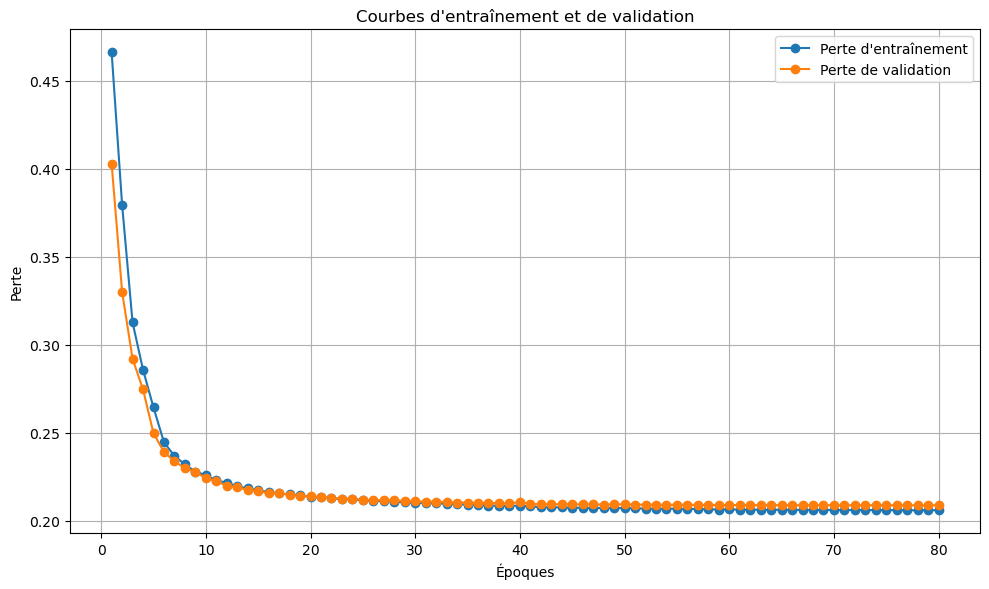

In [74]:
epoch = 80

mae_model = MaskedAutoencoderModel(latent_dim=128)

# Entraîner le modèle et récupérer les pertes
mae_encoder, train_losses, val_losses = train_ssl_model(
    mae_model,
    autovi_train_loader, 
    filtered_autovi_test_loader, 
    criterion=nn.MSELoss(), 
    optimizer=optim.Adam(mae_model.parameters(), lr=0.001),
    epochs=epoch
)

# Tracer les courbes de perte
epochs_range = range(1, epoch + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs_range, train_losses, label='Perte d\'entraînement', marker='o')
plt.plot(epochs_range, val_losses, label='Perte de validation', marker='o')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.title('Courbes d\'entraînement et de validation')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

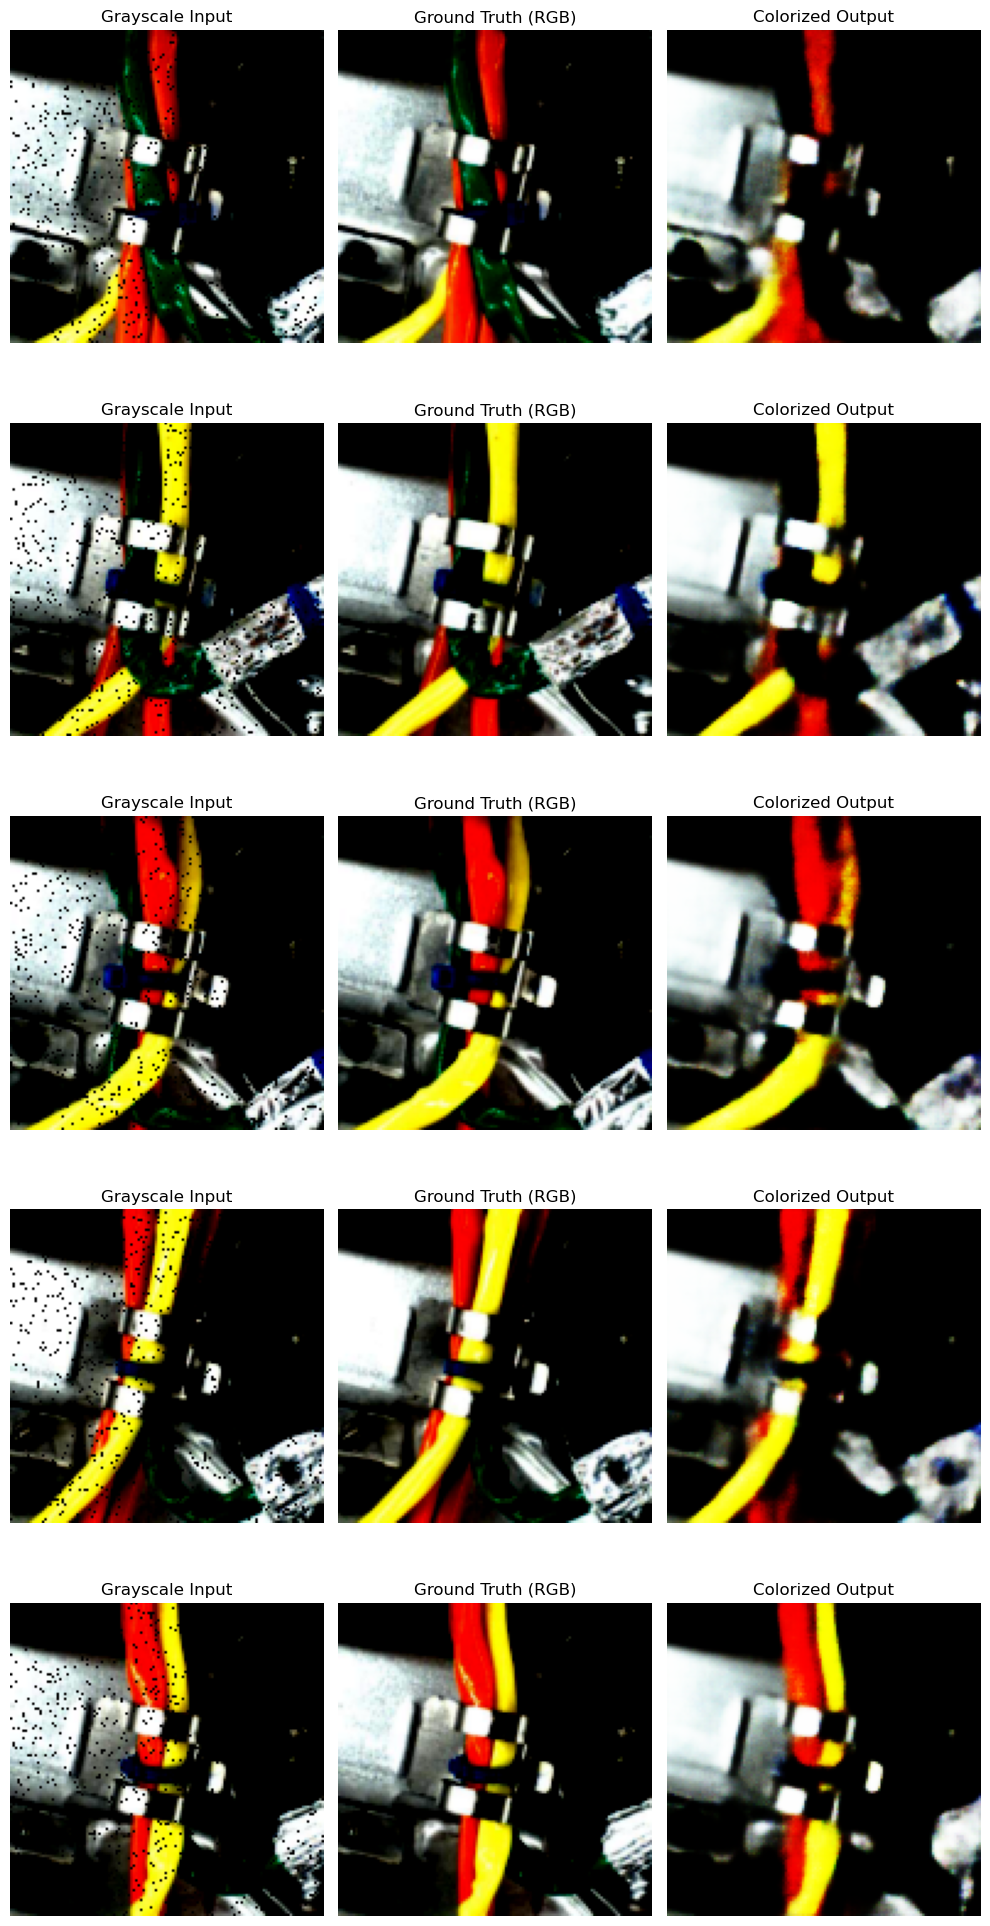

In [75]:
# Exemple d'utilisation
visualize_reconstructions(mae_model, filtered_autovi_test_loader, device, num_images=5)


## (b) Modèle colorization

In [76]:
class ColorizationModel(nn.Module):
    def __init__(self, latent_dim=128):
        super(ColorizationModel, self).__init__()
        self.encoder = Encoder(latent_dim=latent_dim, in_channels=1)  # Input grayscale
        self.decoder = Decoder(latent_dim=latent_dim, out_channels=3)  # Predict RGB

    def forward(self, x):
        grayscale_x = transforms.Grayscale()(x)  # Convert RGB to Grayscale
        z = self.encoder(grayscale_x)
        return self.decoder(z), grayscale_x


Epoch 1/80, Train Loss: 0.4300, Val Loss: 0.4053, Current LR: 0.010000
Epoch 2/80, Train Loss: 0.3647, Val Loss: 0.3103, Current LR: 0.010000
Epoch 3/80, Train Loss: 0.2851, Val Loss: 0.2701, Current LR: 0.010000
Epoch 4/80, Train Loss: 0.2538, Val Loss: 0.2516, Current LR: 0.010000
Epoch 5/80, Train Loss: 0.2413, Val Loss: 0.2442, Current LR: 0.010000
Epoch 6/80, Train Loss: 0.2347, Val Loss: 0.2397, Current LR: 0.010000
Epoch 7/80, Train Loss: 0.2310, Val Loss: 0.2374, Current LR: 0.010000
Epoch 8/80, Train Loss: 0.2274, Val Loss: 0.2344, Current LR: 0.010000
Epoch 9/80, Train Loss: 0.2254, Val Loss: 0.2322, Current LR: 0.010000
Epoch 10/80, Train Loss: 0.2234, Val Loss: 0.2309, Current LR: 0.010000
Epoch 11/80, Train Loss: 0.2214, Val Loss: 0.2292, Current LR: 0.010000
Epoch 12/80, Train Loss: 0.2203, Val Loss: 0.2289, Current LR: 0.010000
Epoch 13/80, Train Loss: 0.2189, Val Loss: 0.2274, Current LR: 0.010000
Epoch 14/80, Train Loss: 0.2178, Val Loss: 0.2272, Current LR: 0.010000
E

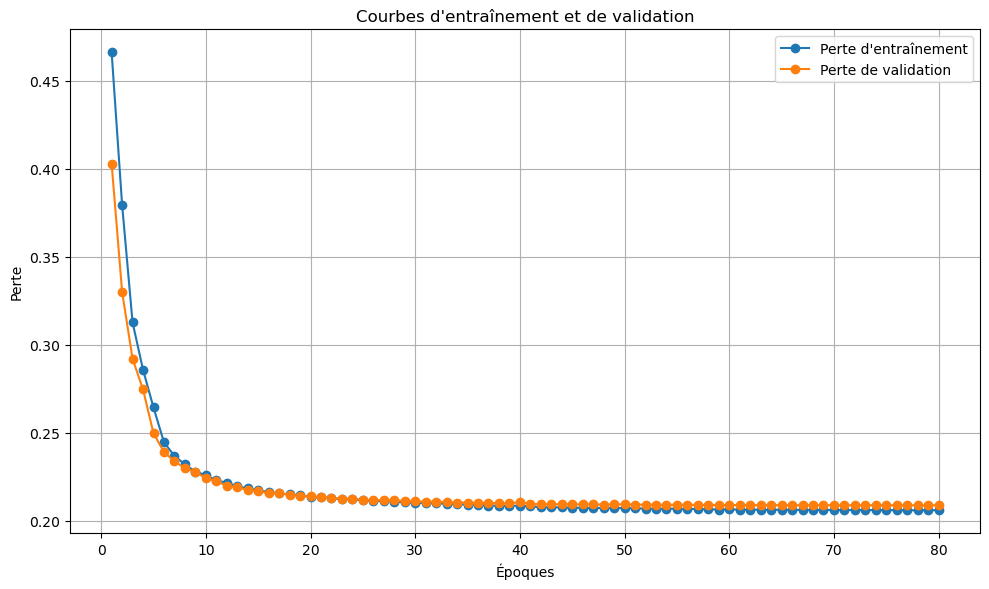

In [94]:
epoch = 80
colorization_model = ColorizationModel(latent_dim=128)
colorization_encoder = train_ssl_model(colorization_model,
                              autovi_train_loader, 
                              autovi_test_loader, 
                              criterion=nn.MSELoss(), 
                              optimizer=optim.Adam(colorization_model.parameters(), lr=0.01),
                              epochs=epoch
                              )

# Tracer les courbes de perte
epochs_range = range(1, epoch + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs_range, train_losses, label='Perte d\'entraînement', marker='o')
plt.plot(epochs_range, val_losses, label='Perte de validation', marker='o')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.title('Courbes d\'entraînement et de validation')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


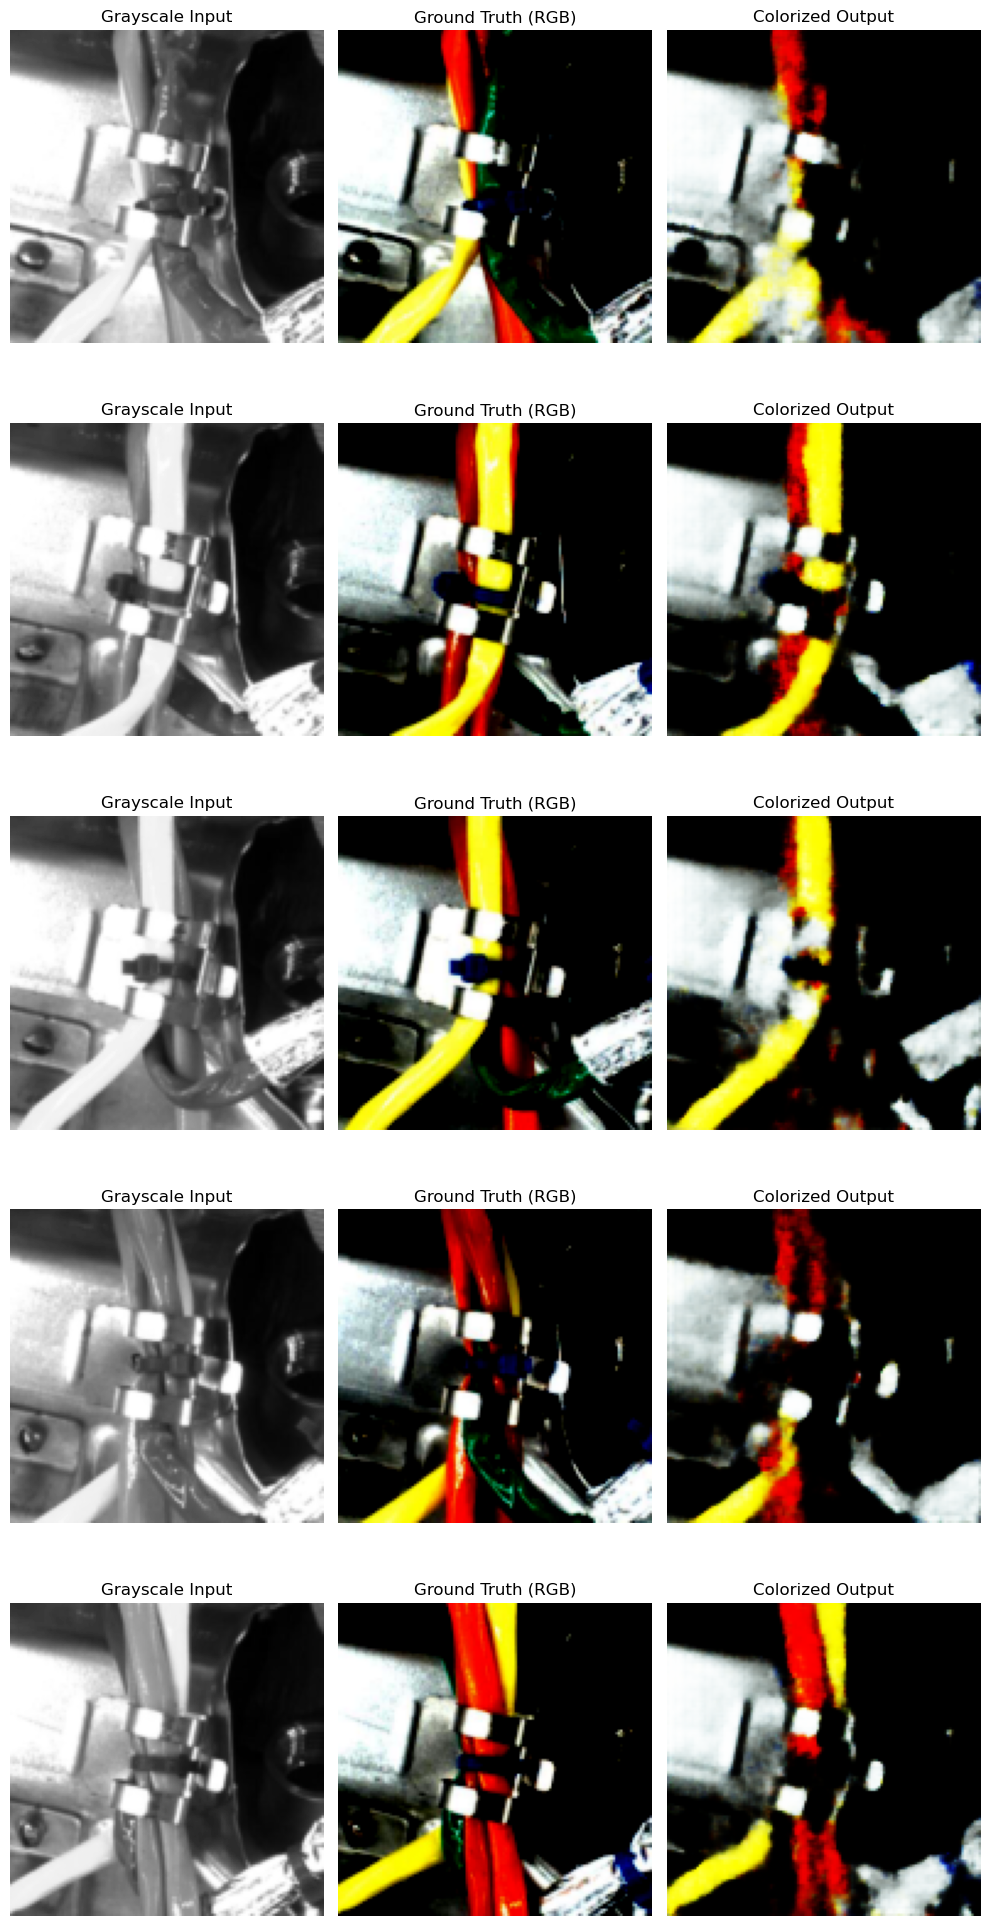

In [95]:
visualize_reconstructions(colorization_model, filtered_autovi_test_loader, device, num_images=5)


## (c) Modèle d’inpainting

In [91]:
class InpaintingModel(nn.Module):
    def __init__(self, latent_dim=128, mask_size=8):
        super(InpaintingModel, self).__init__()
        self.encoder = Encoder(latent_dim=latent_dim)
        self.decoder = Decoder(latent_dim=latent_dim)
        self.mask_size = mask_size

    def forward(self, x):
        x_masked = self.apply_mask(x)
        z = self.encoder(x_masked)
        return self.decoder(z), x_masked
    
    def apply_mask(self, x):
        masked_x = x.clone()

        for i in range(masked_x.size(0)):
            ul_x = np.random.randint(0, x.size(2) - self.mask_size + 1)
            ul_y = np.random.randint(0, x.size(3) - self.mask_size + 1)
            masked_x[i, :, ul_x:ul_x+self.mask_size, ul_y:ul_y+self.mask_size] = 0

        return masked_x


Epoch 1/80, Train Loss: 0.4624, Val Loss: 0.4054, Current LR: 0.001000
Epoch 2/80, Train Loss: 0.4049, Val Loss: 0.3956, Current LR: 0.001000
Epoch 3/80, Train Loss: 0.3532, Val Loss: 0.3176, Current LR: 0.001000
Epoch 4/80, Train Loss: 0.3041, Val Loss: 0.2926, Current LR: 0.001000
Epoch 5/80, Train Loss: 0.2769, Val Loss: 0.2652, Current LR: 0.001000
Epoch 6/80, Train Loss: 0.2530, Val Loss: 0.2538, Current LR: 0.001000
Epoch 7/80, Train Loss: 0.2436, Val Loss: 0.2471, Current LR: 0.001000
Epoch 8/80, Train Loss: 0.2379, Val Loss: 0.2424, Current LR: 0.001000
Epoch 9/80, Train Loss: 0.2334, Val Loss: 0.2385, Current LR: 0.001000
Epoch 10/80, Train Loss: 0.2299, Val Loss: 0.2358, Current LR: 0.001000
Epoch 11/80, Train Loss: 0.2268, Val Loss: 0.2326, Current LR: 0.001000
Epoch 12/80, Train Loss: 0.2241, Val Loss: 0.2305, Current LR: 0.001000
Epoch 13/80, Train Loss: 0.2224, Val Loss: 0.2291, Current LR: 0.001000
Epoch 14/80, Train Loss: 0.2209, Val Loss: 0.2278, Current LR: 0.001000
E

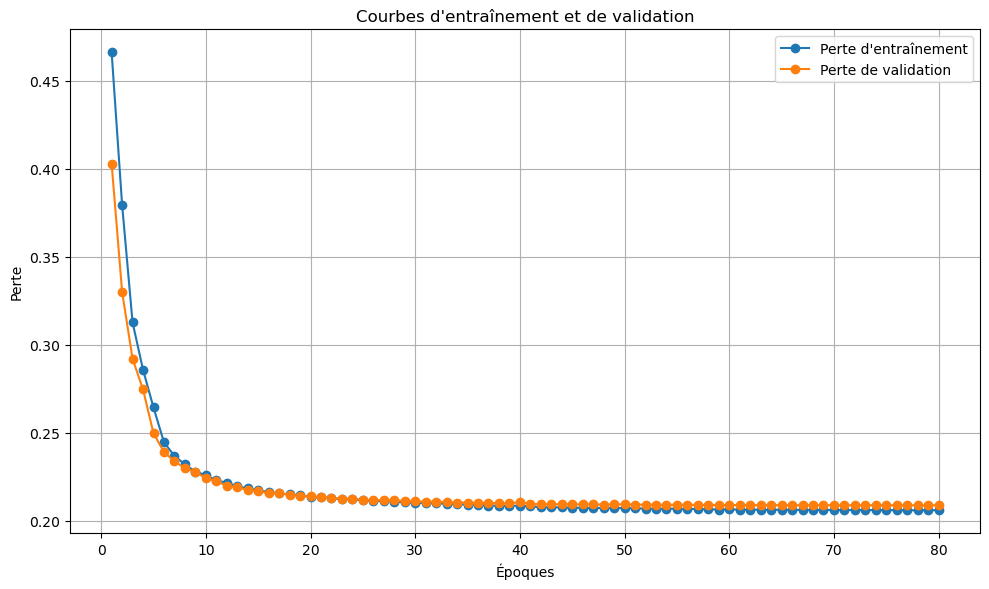

In [97]:
epoch = 80

Inpainting_Model = InpaintingModel(latent_dim=128)
Inpainting_encoder = train_ssl_model(Inpainting_Model,
                              autovi_train_loader, 
                              autovi_test_loader, 
                              criterion=nn.MSELoss(), 
                              optimizer=optim.Adam(Inpainting_Model.parameters(), lr=0.001),
                              epochs=epoch
                                    )




# Tracer les courbes de perte
epochs_range = range(1, epoch + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs_range, train_losses, label='Perte d\'entraînement', marker='o')
plt.plot(epochs_range, val_losses, label='Perte de validation', marker='o')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.title('Courbes d\'entraînement et de validation')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

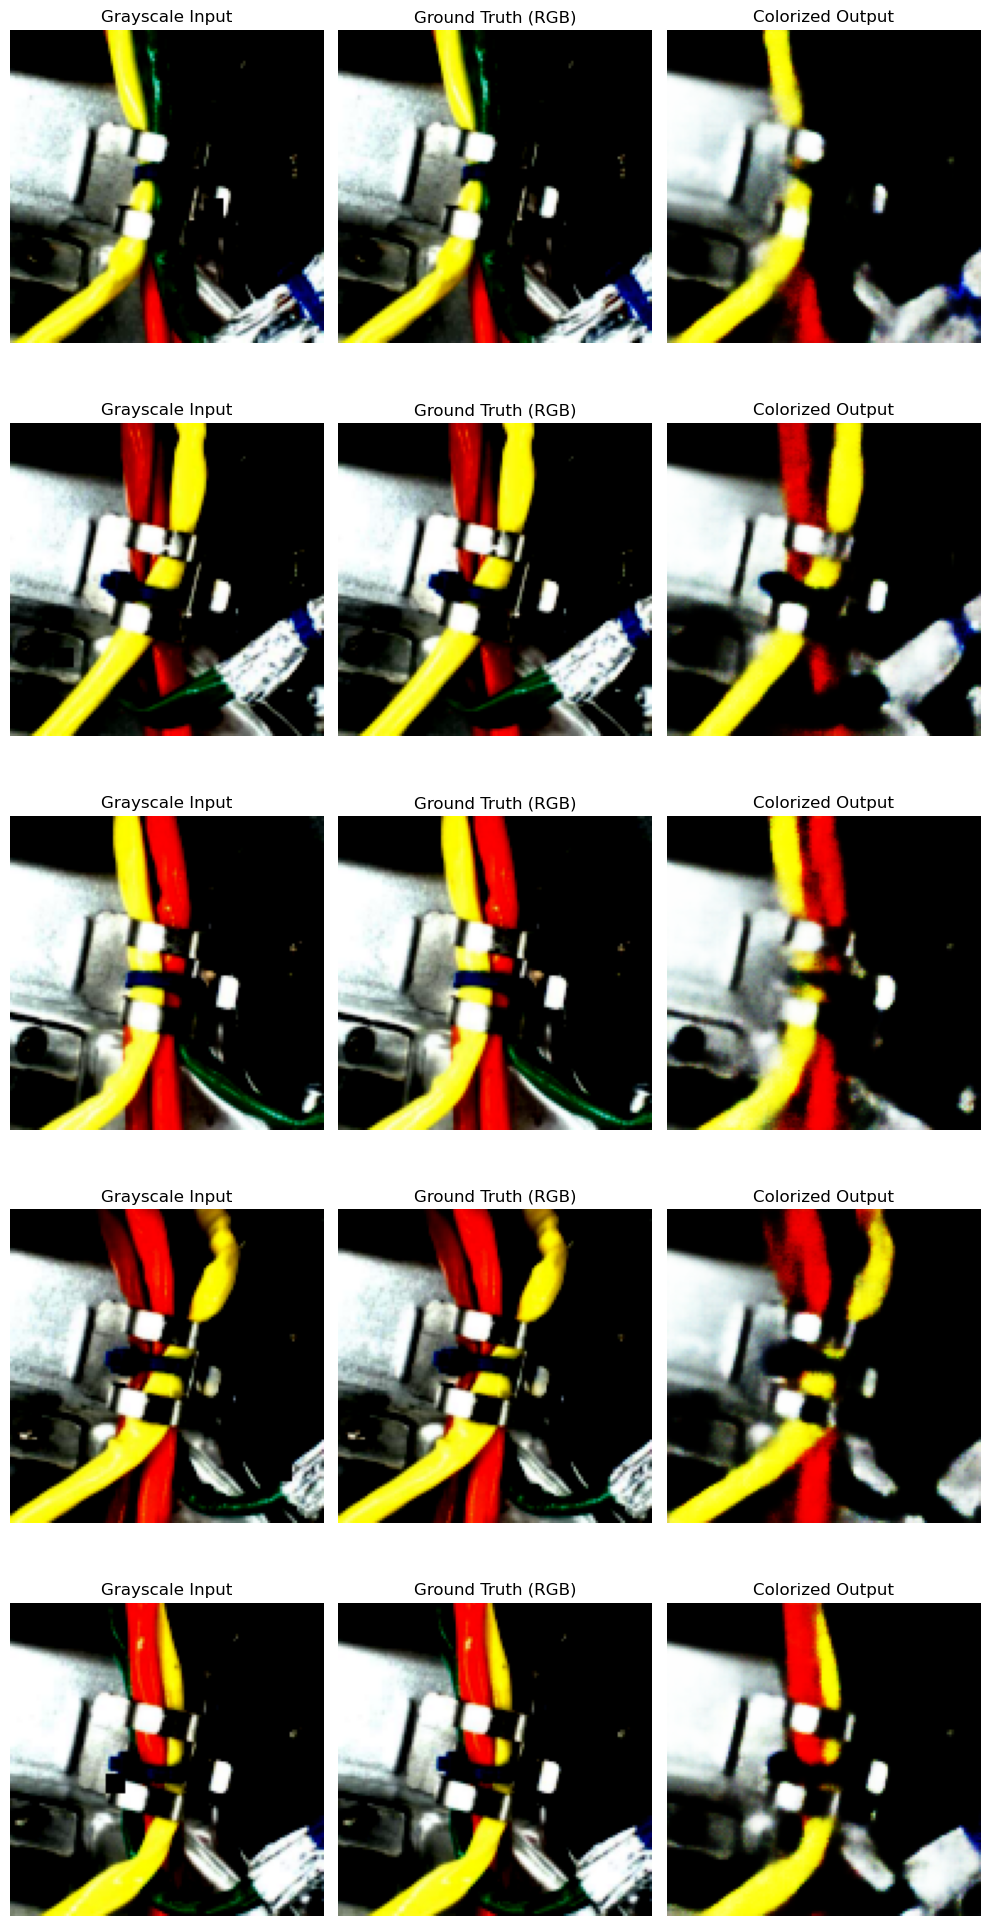

In [98]:
visualize_reconstructions(Inpainting_Model, filtered_autovi_test_loader, device, num_images=5)

# 4. Évaluation des performances avec les métriques AUROC et courbes ROC

In [ ]:
from sklearn.metrics import roc_curve, auc

def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    y_true = []
    y_scores = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            reconstructed, _ = model(images)
            loss = criterion(reconstructed, images).item()
            y_scores.append(loss)
            y_true.extend(labels.cpu().numpy())

    # Courbe ROC
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="best")
    plt.title("ROC Curve")
    plt.show()
